# Indlæser pakker

In [21]:
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path # To make relative paths

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error as mse
import statistics as stat
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Sætter paths

In [22]:
my_path = Path.cwd() # Path to current directory
project_path = my_path.parents[0] # Path to project directory
data_path = project_path / 'Data' # Path to data folder
figure_path = project_path / 'Figures' # Path to data folder

data_path

WindowsPath('C:/Users/nld/Introduction to Data Science/Exam Project/Data')

# Indlæser data

In [23]:
# Samlet data
final_df = pd.read_parquet(data_path/'ML_Dataset.parquet', engine='pyarrow')

# ML

## Klargør data til ML

In [24]:
# Dividerer pris med 1 mio.
final_df['priceMil'] = final_df['priceCash']/1000000

In [25]:
# Udvælger variable
model_df = final_df[['priceMil', 'propertyType', 'energyClass', 
                     'rooms', 'size', 'lotSize', 'basementSize', 'exp',
                   'buildYear', 
                     'municipality']].reset_index(drop=True)

In [26]:
# Fjerner observationer med fejl i expenses
model_df = model_df[(model_df['exp']<100000) & (model_df['exp']!=0)]
len(model_df)


42709

In [27]:
# Make dummy variables
# Create dummy variables for propertyType, energyClass, and area
model_df_dummies = pd.get_dummies(model_df, columns=['propertyType', 'energyClass', 'municipality'], drop_first=True)

In [28]:
# Define x and y variables
X = model_df_dummies.drop('priceMil', axis=1)  # Features (drop the target variable)
y = model_df_dummies['priceMil']               # Target variable

In [29]:
# 1. Split data data into development and test
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=161193)

In [30]:
X_dev = X_dev.reset_index(drop = True)
y_dev = y_dev.reset_index(drop = True)


## Ridge

### 1. Cross validation
Laver k-fold cross validation med forskellige parametre af lambda for at finde optimalt lambda

In [31]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=2)
folds = list(kfolds.split(X_dev, y_dev))
folds

# Define lambds
lambdas =  np.logspace(0, 10, 12)

# Outer loop: lambdas
mseCV = []
for lambda_ in lambdas:    
    
    # Inner loop: folds
    mseCV_ = []    
    for train_idx, val_idx in folds:        
        
        # Train model and compute MSE on test fold
        # Make pipeline
        pipe_ridge = make_pipeline(PolynomialFeatures(degree = 2, include_bias=False),
                                     StandardScaler(),
                                     Ridge(alpha=lambda_, random_state=161193))   
        # Split development data into training and validation data
        X_train, y_train = X_dev.iloc[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev[val_idx] 
        
        # Train the model using pipe_lasso
        pipe_ridge.fit(X_train, y_train)
        
        # Calculate MSE for validation data
        mseCV_.append(mse(pipe_ridge.predict(X_val), y_val))    
        print(mseCV_)
    
    # Calculate average mean squared error in validation data
    avg_mse = stat.mean(mseCV_) 

    # Store result    
    mseCV.append(avg_mse) 
    


[5.804795662244842]
[5.804795662244842, 5.5392109620577505]
[3.856087805360606]
[3.856087805360606, 4.272492334953958]
[2.8160534033386817]
[2.8160534033386817, 3.7121302265928824]
[2.701506306942553]
[2.701506306942553, 4.025956245940518]
[2.702071328291736]
[2.702071328291736, 4.01930563585325]
[3.8439091757591393]
[3.8439091757591393, 3.311862545615724]
[8.886122019776636]
[8.886122019776636, 7.030680623525166]
[13.76359564167562]
[13.76359564167562, 12.308194260444541]
[14.857295291509036]
[14.857295291509036, 13.58804189636587]
[15.005331207275194]
[15.005331207275194, 13.76345013063359]
[15.023800873430508]
[15.023800873430508, 13.78537008282439]
[15.026081268125994]
[15.026081268125994, 13.788077013073302]


In [32]:
# Convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)
lambdaCV

# Find the index of the minimum RMSE for the test set
min_mse_val_index = np.argmin(mseCV)

# Find the corresponding lambda value
optimal_lambda = lambdas[min_mse_val_index]

# Find the corresponding minimum RMSE value
min_mse_val = mseCV[min_mse_val_index]

print(f"The optimal lambda (alpha) that gives the lowest test AMSE is: {optimal_lambda}")
print(f"The lowest test AMSE is: {min_mse_val}")
lambdaCV

The optimal lambda (alpha) that gives the lowest test AMSE is: 65.79332246575679
The lowest test AMSE is: 3.264091814965782


,0
1.000000e+00,5.672003
8.111308e+00,4.064290
6.579332e+01,3.264092
5.336699e+02,3.363731
4.328761e+03,3.360688
3.511192e+04,3.577886
2.848036e+05,7.958401
2.310130e+06,13.035895
1.873817e+07,14.222669
1.519911e+08,14.384391


In [33]:
# LOAD FROM SCIKIT-LEARN
from sklearn.model_selection import validation_curve

# Define lambds
lambdas =  np.logspace(0, 10, 25)

# FIT AND EVALUATE FOR DIFFERENT LAMBDAS
train_scores, test_scores = \
    validation_curve(estimator=pipe_ridge,
                     X=X_dev,
                     y=y_dev,
                     param_name='ridge__alpha', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='neg_mean_squared_error',                 
                     cv=5)

# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

# YAY we get the same result as in the previous excercise

lambda
316.227766    2.571808
Name: Validation, dtype: float64


### 2. Plotter MSE for forskellige værdier af lambda

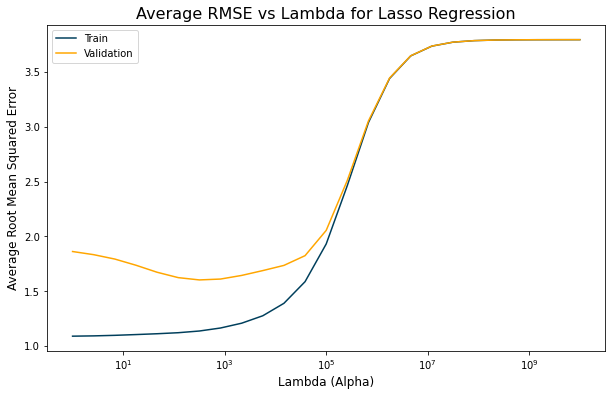

In [34]:
# Plot average MSE for train and test data against different values of lambda
plt.figure(figsize=(10, 6))
plt.plot(lambdas, np.sqrt(mse_score['Train']), label='Train', color = '#003f5c')
plt.plot(lambdas, np.sqrt(mse_score['Validation']), label='Validation', color = '#ffa600')
plt.xscale('log')
plt.xlabel('Lambda (Alpha)', fontsize = 12)
plt.ylabel('Average Root Mean Squared Error', fontsize = 12)
plt.title('Average RMSE vs Lambda for Lasso Regression', fontsize = 16)
plt.legend()
# Save the plot as a PNG file
plt.savefig(figure_path/'ridge_full_model_validation_curve_title.jpg', dpi=300, bbox_inches='tight')


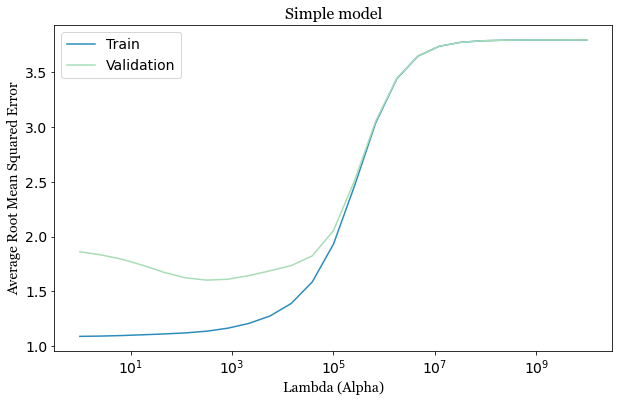

In [51]:
# Assuming lambdas and mse_score are already defined
plt.figure(figsize=(10, 6))
plt.plot(lambdas, np.sqrt(mse_score['Train']), label='Train', color='#2b8cbe')
plt.plot(lambdas, np.sqrt(mse_score['Validation']), label='Validation', color='#a8ddb5')
plt.xscale('log')
plt.xlabel('Lambda (Alpha)', font='Georgia', fontsize=14)
plt.ylabel('Average Root Mean Squared Error', font='Georgia', fontsize=14)
plt.title('Simple model', font='Georgia', fontsize=16)
plt.legend(fontsize=14)  # Set legend font to Georgia
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Save the plot as a PNG file
plt.savefig(figure_path/'ridge_simple_model_validation_curve.jpg', dpi=300, bbox_inches='tight')


### 3. Fitter model på hele træningsdata

In [35]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Suppose you have chosen a specific lambda value from the mse_score DataFrame
chosen_lambda = mse_score.Validation.idxmin()  # Selects the lambda with the smallest validation error

# Recreate the pipeline (if not already defined)
pipe_ridge = make_pipeline(PolynomialFeatures(degree = 2, include_bias=False),
                                     StandardScaler(),
                                     Ridge(alpha=chosen_lambda, random_state=161193))   

# Fit the model on the entire development set (or a training set)
pipe_ridge.fit(X_dev, y_dev)

# Access the coefficients (beta parameters)
beta_parameters = pipe_ridge.named_steps['ridge'].coef_

# Optionally, you can also access the intercept
intercept = pipe_ridge.named_steps['ridge'].intercept_

print("Beta coefficients:", beta_parameters)
print("Intercept:", intercept)


Beta coefficients: [ 0.05749241  0.2940843   0.11083672 ... -0.03535812  0.
 -0.05945703]
Intercept: 3.142992070279566


### 4. Tester på model

In [36]:
from sklearn.metrics import r2_score

# Beregner MSE på baggrund af testdata
mse(pipe_ridge.predict(X_test), y_test)

# Calculate predictions
y_pred = pipe_ridge.predict(X_test)

# Beregner MSE på baggrund af testdata
print(f"MSE: {mse(y_pred, y_test):.4f}")
print(f"R2: {r2_score(y_pred, y_test, sample_weight=None, multioutput=None):.4f}")

# print(f"MSE: {mse(y_test, y_pred):.4f}")
# print(f"R2: {r2_score(y_test, y_pred, sample_weight=None, multioutput=None):.4f}")



MSE: 12.3432
R2: 0.4209


### 5. Finder parameterestimater

In [38]:
#  Retrieve the feature names from the PolynomialFeatures step
feature_names = pipe_ridge.named_steps['polynomialfeatures'].get_feature_names_out(input_features=X_dev.columns)

# # Identify the non-zero coefficients
non_zero_indices = beta_parameters != 0
non_zero_coefficients = beta_parameters[non_zero_indices]

# Get corresponding feature names for non-zero coefficients
selected_features = feature_names[non_zero_indices]

# Create a DataFrame for easy visualization
non_zero_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': non_zero_coefficients
})

# print(non_zero_df)
non_zero_df.sort_values('Coefficient')

,Feature,Coefficient
589,exp propertyType_3,-0.610280
697,exp municipality_846.0,-0.457667
121,rooms lotSize,-0.360065
590,exp propertyType_6,-0.357472
475,basementSize propertyType_3,-0.320951
...,...,...
244,size propertyType_3,0.466553
123,rooms exp,0.495574
239,size lotSize,0.532513
587,exp buildYear,0.961912


In [39]:
# Create a DataFrame for easy visualization
all_betas = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': beta_parameters
})
all_betas[0:121][all_betas[0:121]['Coefficient']!=0].sort_values('Coefficient')

,Feature,Coefficient
120,rooms size,-0.202801
119,rooms^2,-0.099378
81,municipality_561.0,-0.096567
99,municipality_740.0,-0.091015
85,municipality_580.0,-0.066738
...,...,...
7,propertyType_3,0.071010
3,basementSize,0.102035
2,lotSize,0.110837
1,size,0.294084


### 6. Plotter predicted values med actual prices

In [40]:
y_predict = pipe_ridge.predict(X_test)

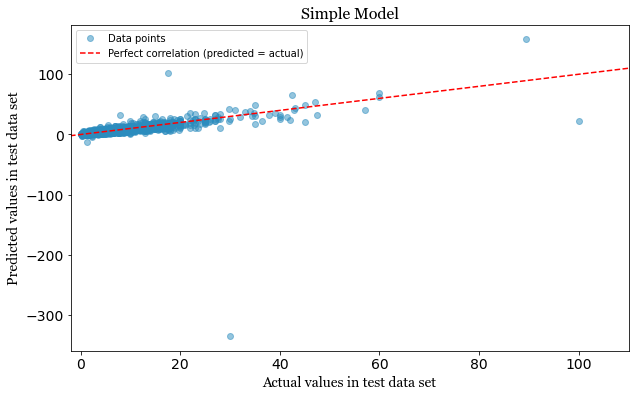

In [54]:
# Create the plot
plt.figure(figsize=(10, 6))

# You can use either a line plot or a scatter plot depending on your data
plt.plot(y_test, y_predict, 'o', label='Data points', color = '#2b8cbe', alpha = 0.5)  # 'o' for scatter plot
# plt.scatter(y_test, y_pred, label='Data points')  # Alternative scatter plot

# Plot the perfect correlation line (y = x)
min_value = min(min(y_test), min(y_predict))
max_value = max(max(y_test), max(y_predict))

plt.plot([min_value, max_value], [min_value, max_value], color='red', label='Perfect correlation (predicted = actual)', linestyle='--')


# Add labels and title
plt.xlabel('Actual values in test data set', font = 'Georgia', fontsize = 14)
plt.ylabel('Predicted values in test data set', font = 'Georgia', fontsize = 14)
plt.title('Simple Model', font = 'Georgia', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(-2,110)
# plt.ylim(-2,110)


# Add a legend
plt.legend()

# Save the plot as a PNG file
plt.savefig(figure_path/'ridge_simple_model_prediction.jpg', dpi=300, bbox_inches='tight')


In [ ]:
# Næste skridt:
# 1. Fit model på hele træningsdata
# 2. Predict på test data og regn RMSE
# 3. Sammenlign med andre fx Ridge
# 4. Plot predicted og actual prices